In [75]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

imagem = cv2.imread('imgs\\Q5\\Merge_Timex_BoaViagem.png')

# Converter BGR para HSV
imagem_hsv = cv2.cvtColor(imagem, cv2.COLOR_BGR2HSV)

# Kernel para operações morfológicas
kernel_3x3 = np.ones((3, 3), np.uint8)
kernel_5x5 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
kernel_11x11 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
kernel_20x11 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 11))

# Faixa para tons avermelhados a alaranjados 
tom_vermelhado_inf = np.array([0, 70, 0])    
tom_vermelhado_sup = np.array([30, 255, 255])

msk_tom_vermelhado = cv2.inRange(imagem_hsv, tom_vermelhado_inf, tom_vermelhado_sup)

# Utilização de operações mofológicas para ajustes na máscara
msk_tom_vermelhado = cv2.dilate(msk_tom_vermelhado, kernel_3x3, iterations=1)
msk_tom_vermelhado = cv2.morphologyEx(msk_tom_vermelhado, cv2.MORPH_CLOSE, kernel_3x3)

#----------------------------------------------------------------------------------------------------------
#Faixa para os tons escuros
tom_escuro_inf = np.array([0, 0, 50])
tom_escuro_sup = np.array([180, 255, 255])

msk_tom_escuro = cv2.inRange(imagem_hsv, tom_escuro_inf, tom_escuro_sup)

# Utilização de operações mofológicas para ajustes na máscara
msk_tom_escuro = cv2.erode(msk_tom_escuro, kernel_3x3, iterations=2)

#----------------------------------------------------------------------------------------------------------
# Faixa para tons de bege/areia clara
tom_bege_inf = np.array([25, 0, 150])
tom_bege_sup = np.array([30, 255, 255])

msk_tom_bege = cv2.inRange(imagem_hsv, tom_bege_inf, tom_bege_sup)
# Inverter máscara de bege (areia) para obter a faixa do mar
msk_tom_bege_inv = cv2.bitwise_not(msk_tom_bege)

msk_bege_escuro = cv2.bitwise_and(msk_tom_escuro, msk_tom_bege_inv)

# Criar máscara final combinando vermelho-laranja filtrado e areia
msk_final = np.where((msk_tom_vermelhado == 0) & (msk_bege_escuro == 255), 0, 255).astype('uint8')
msk_final_s = msk_final
# Refinar máscara final com erosão e dilatação
msk_final = cv2.morphologyEx(msk_final, cv2.MORPH_OPEN, kernel_5x5)
msk_final = cv2.morphologyEx(msk_final, cv2.MORPH_OPEN, kernel_5x5)
msk_final = cv2.dilate(msk_final, kernel_5x5, iterations=1)

# Aplicar abertura e fechamento morfológico para limpar máscara final
msk_final = cv2.morphologyEx(msk_final, cv2.MORPH_OPEN, kernel_20x11)
msk_final = cv2.morphologyEx(msk_final, cv2.MORPH_OPEN, kernel_20x11)
msk_final = cv2.morphologyEx(msk_final, cv2.MORPH_CLOSE, kernel_20x11)


# Aplicar abertura (erosão seguida de dilatação) para remover pequenos ruídos
msk_final = cv2.morphologyEx(msk_final, cv2.MORPH_OPEN, kernel_11x11, iterations=3)
msk_final = cv2.dilate(msk_final, kernel_5x5, iterations=3)
msk_final = cv2.erode(msk_final, kernel_5x5, iterations=3)

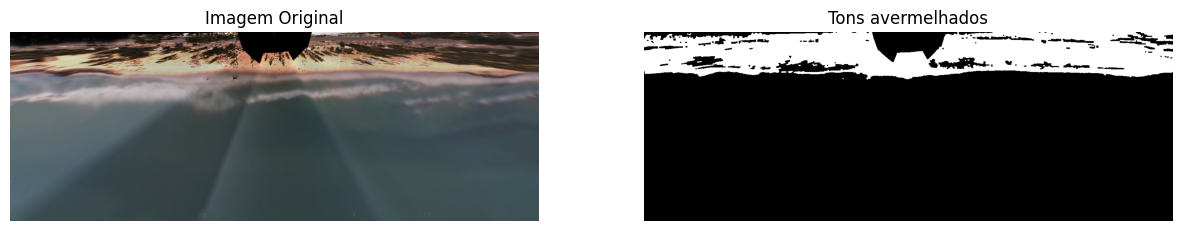

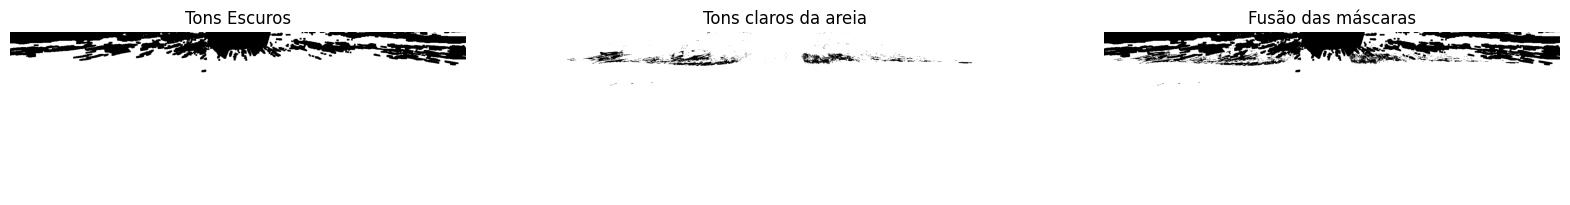

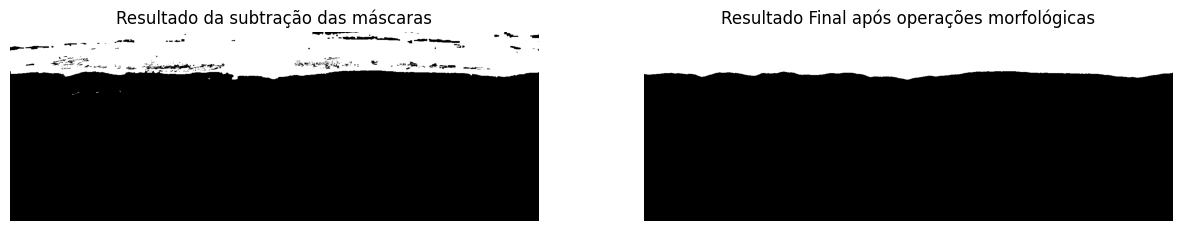

In [ ]:
# Mostrar resultados
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.title('Imagem Original')
plt.imshow(cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Tons avermelhados')
plt.imshow(msk_tom_vermelhado, cmap='gray')
plt.axis('off')
plt.show()

plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.title('Tons Escuros')
plt.imshow(msk_tom_escuro, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Tons claros da areia')
plt.imshow(msk_tom_bege_inv, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Fusão das máscaras')
plt.imshow(msk_bege_escuro, cmap='gray')
plt.axis('off')
plt.show()

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.title('Resultado da subtração das máscaras')
plt.imshow(msk_final_s, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Resultado Final após operações morfológicas')
plt.imshow(msk_final, cmap='gray')
plt.axis('off')
plt.show()

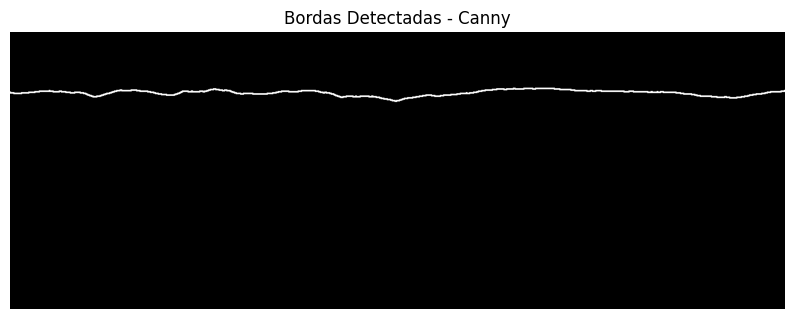

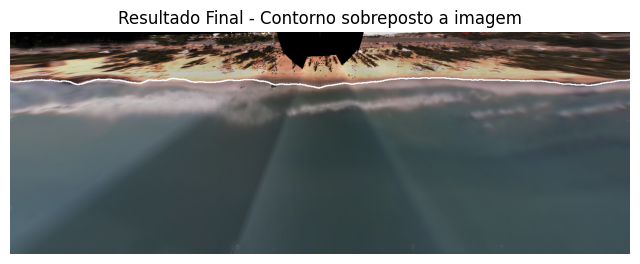

In [77]:
# Definir limiares baixo e alto para o Canny
threshold1 = 50
threshold2 = 150

# Aplicar detector de bordas Canny na máscara (que deve ser imagem em escala de cinza)
edges = cv2.Canny(msk_final, threshold1, threshold2)

kernel_3x3 = np.ones((3,3), np.uint8)

# Dilatar as bordas para engrossar o contorno
edges = cv2.dilate(edges, kernel_3x3, iterations=1) 

# Mostrar resultado das bordas
plt.figure(figsize=(10, 6))
plt.title('Bordas Detectadas - Canny')
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.show()

# Criar cópia da imagem original
img_final = imagem.copy()

# Para os pixels onde edges == 255, colocar branco ([255, 255, 255])
img_final[edges == 255] = [255, 255, 255]

# Exibir imagem resultante (colorida)
plt.figure(figsize=(8,6))
plt.title("Resultado Final - Contorno sobreposto a imagem")
plt.imshow(cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB))  # converter para RGB para matplotlib
plt.axis('off')
plt.show()

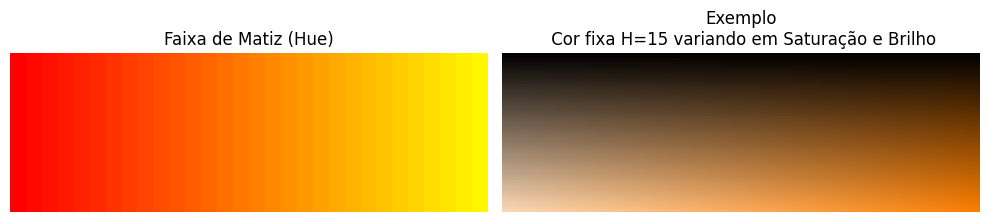

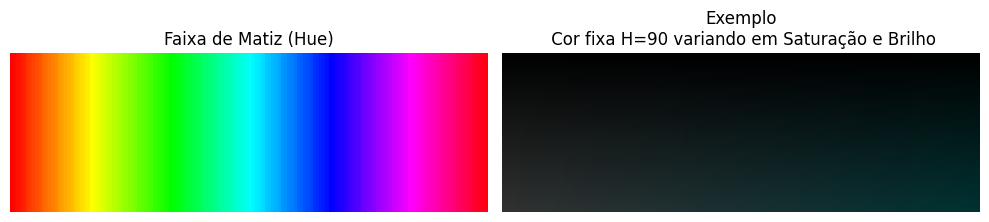

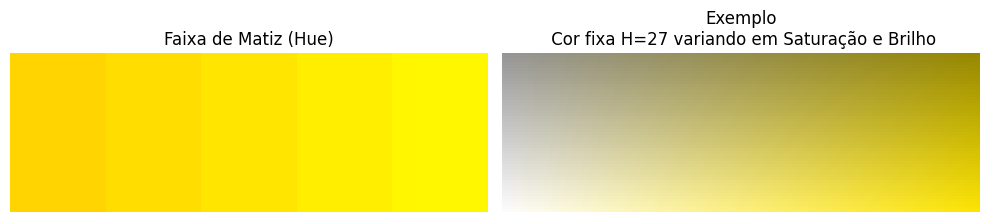

In [ ]:
def visualizar_faixa_hsv(h_inf, h_sup, s_inf, s_sup, v_inf, v_sup):
    """
    Gera duas imagens:
    1. Faixa de variação de Matiz (Hue)
    2. Cor fixa sendo exibida com variação de Saturação e Brilho
    
    Parâmetros:
    - h_inf, h_sup: Intervalo de Hue (Matiz)
    - s_inf, s_sup: Intervalo de Saturação
    - v_inf, v_sup: Intervalo de Brilho
    """
    
    altura, largura = 50, 150  # Dimensão da imagem

    # Criando imagem Hue (variação horizontal)
    hsv_h = np.zeros((altura, largura, 3), dtype=np.uint8)
    for x in range(largura):
        h = int(h_inf + (x / largura) * (h_sup - h_inf))
        hsv_h[:, x] = [h, 255, 255]  # Saturação e Valor fixos no máximo

    # Criando imagem fixa variando Saturação e Brilho
    hsv_sv = np.zeros((altura, largura, 3), dtype=np.uint8)
    cor_fixa = (h_inf + h_sup) // 2  # Matiz médio como referência de cor fixa
    for y in range(altura):
        for x in range(largura):
            s = int(s_inf + (x / largura) * (s_sup - s_inf))
            v = int(v_inf + (y / altura) * (v_sup - v_inf))
            hsv_sv[y, x] = [cor_fixa, s, v]

    # Convertendo para RGB para exibição
    rgb_h = cv2.cvtColor(hsv_h, cv2.COLOR_HSV2RGB)
    rgb_sv = cv2.cvtColor(hsv_sv, cv2.COLOR_HSV2RGB)

    # Criando os gráficos
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(rgb_h)
    axes[0].set_title("Faixa de Matiz (Hue)")
    axes[0].axis("off")

    axes[1].imshow(rgb_sv)
    axes[1].set_title(f"Exemplo\n Cor fixa H={cor_fixa} variando em Saturação e Brilho")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

# Exemplo de uso da função
visualizar_faixa_hsv(0, 30, 70, 255, 0, 255)
visualizar_faixa_hsv(0, 180, 0, 255, 0, 50)
visualizar_faixa_hsv(25, 30, 0, 255, 150, 255) 